# Process gridded CMIP6 model data into timeseries

__1. Process the gridded temperature data into timeseries for each model.__

Output is a dataArray for each model with dimensions of time and IPCC region containing a time series of the TAS variable.


Use this tool:  

~~https://github.com/IPCC-WG1/Atlas/blob/main/notebooks/reference-regions_Python.ipynb~~

Nathan has recommended a tool that not only identifies gridcells within regions but also weights them based on the fraction within a region. We want to avoid land-ocean regions contamination.  

https://xagg.readthedocs.io/en/latest/notebooks/full_run.html

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

import xagg as xa
import geopandas as gpd

%matplotlib inline

In [2]:
def fix_cesm_time(ds):
    '''Fix CESM-style time coordinate issue. Make a new object to avoid confusion!'''
    
    new_ds = ds.copy()
    
    try:
        new_ds['time'] = new_ds['time_bnds'].isel(bnds=0)
    except:
        new_ds['time'] = new_ds['time_bnds'].isel(nbnd=0)
        
    return new_ds

__PI-Control Simulations.__  

Nicola/MPI: /glade/scratch/nmaher/mpi_jonah  

CESM1-LE: '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'


In [3]:
# mpi_pic_dir = '/glade/scratch/nmaher/mpi_jonah/'
cesm1_pic_dir   = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'
mpi_pic_dir     = '/glade/derecho/scratch/jonahshaw/CMIP5/MPI-GE/'
canesm2_pic_dir = '/glade/derecho/scratch/jonahshaw/CMIP5/CanESM2/'
esm2m_pic_dir   = '/glade/derecho/scratch/jonahshaw/CMIP5/GFDL-ESM2M/'

#### Collect CESM1 PIC file paths.

In [4]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [5]:
cesm1_pic_tas_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1_pic_dir,cesm1_cmor_var_dict['tas']))
cesm1_pic_tas_files.sort()

cesm1_pic_ts_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1_pic_dir,cesm1_cmor_var_dict['ts']))
cesm1_pic_ts_files.sort()

In [6]:
mpi_pic_tas_files = glob.glob('%s/*%s*.nc' % (mpi_pic_dir,'tas'))
mpi_pic_tas_files.sort()

mpi_pic_ts_files = glob.glob('%s/*%s*.nc' % (mpi_pic_dir,'ts'))
mpi_pic_ts_files.sort()

In [7]:
canesm2_pic_tas_files = glob.glob('%s/*%s*.nc' % (canesm2_pic_dir,'tas'))
canesm2_pic_tas_files.sort()

canesm2_pic_ts_files = glob.glob('%s/*%s*.nc' % (canesm2_pic_dir,'ts'))
canesm2_pic_ts_files.sort()

In [8]:
esm2m_pic_tas_files = glob.glob('%s/*%s*.nc' % (esm2m_pic_dir,'tas'))
esm2m_pic_tas_files.sort()

# Nothing here, but that's fine.
esm2m_pic_ts_files = glob.glob('%s/*%s*.nc' % (esm2m_pic_dir,'ts'))
esm2m_pic_ts_files.sort()

Oh no, the MPI files are missing! They were probably removed because they were in Scratch. Well shit, I might need to email Nicola again.

Organize file paths into a dictionary indexed by the variable.

In [9]:
lens_vars = ['tas','ts',]

cesm1_pic_path_dict = {
    'tas':cesm1_pic_tas_files,
    'ts' :cesm1_pic_ts_files,
}

mpi_pic_path_dict = {
    'tas':mpi_pic_tas_files,
    'ts' :mpi_pic_ts_files,
}

canesm2_pic_path_dict = {
    'tas':canesm2_pic_tas_files,
    'ts' :canesm2_pic_ts_files,
}

esm2m_pic_path_dict = {
    'tas':esm2m_pic_tas_files,
    'ts' :esm2m_pic_ts_files,
}

### Load a process timeseries according to IPCC Region designations.

In [39]:
def create_ipccregion_timeseries_xagg(
    ds_filepath:str,
    ds_var:str,
    model_str:str,
    cesm=False,
    read_wm=True,
    write_wm=True,
):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    Now using xagg to appropriately weight gridcells that fall partly within a region!
    '''
    # Load data
    ds = xr.open_dataset(ds_filepath)
    
    # Correct time if CESM
    if cesm:
        ds  = fix_cesm_time(ds)
    
    da = ds[ds_var]

    xagg_dir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/xagg_resources"
    if (read_wm and os.path.exists(os.path.join(xagg_dir, f'wm_{model_str}'))):
        # Load weightmap
        weightmap = xa.read_wm(os.path.join(xagg_dir, f'wm_{model_str}'))
    else:
        # Load IPCC region shp file:
        ipcc_wgi_regions_shp = "IPCC-WGI-reference-regions-v4.shp"
        gdf = gpd.read_file(os.path.join(xagg_dir, ipcc_wgi_regions_shp))
                
        # Compute weights for entire grid. Assuming lat, lon, time dimension on input
        area_weights = np.cos(np.deg2rad(da.lat)).broadcast_like(da.isel(time=0).squeeze())
        
        weightmap = xa.pixel_overlaps(da, gdf, weights=area_weights)
        # Save the weightmap for later:
        if write_wm:
            weightmap.to_file(os.path.join(xagg_dir, f'wm_{model_str}'))

    # Aggregate
    with xa.set_options(silent=True):
        aggregated = xa.aggregate(da, weightmap)
    # aggregated = xa.aggregate(da, weightmap)
    
    # Convert to an xarray dataset
    aggregated_ds = aggregated.to_dataset()
    # Change xarray formatting to match previous file organization.
    aggregated_ds = aggregated_ds.set_coords(("Continent", "Type", "Name", "Acronym")).rename({"poly_idx": "RegionIndex", "Name": "RegionName", "Acronym": "RegionAbbrev"})
        
    return aggregated_ds

In [14]:
xagg_test = create_ipccregion_timeseries_xagg(
    ds_filepath=cesm1_pic_path_dict['tas'][0],
    ds_var=cesm1_cmor_var_dict['tas'],
    model_str="CESM1",
    cesm=True
)


### Loop over CESM1 PI-Control files and compute the regional means.

In [15]:
save_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'

#### CESM1-CAM5 (CESM1-LE)

In [23]:
model_subdir = 'CESM1'

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

for _ds_filepath in cesm1_pic_path_dict['tas']:

    _regional_tseries = create_ipccregion_timeseries_xagg(
        ds_filepath=_ds_filepath,
        ds_var=cesm1_cmor_var_dict['tas'],
        model_str=model_subdir,
        cesm=True
    )

    filename = _ds_filepath.split('/')[-1]

    _save_dir = os.path.join(save_dir,model_subdir, "xagg")
    if not os.path.exists(_save_dir):
        os.makedirs(_save_dir)
    _outfilepath = os.path.join(_save_dir, filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)
    # break

aggregating TREFHT...
all variables aggregated to polygons!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CESM1/xagg/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.040001-049912.nc
aggregating TREFHT...
all variables aggregated to polygons!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CESM1/xagg/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.050001-059912.nc
aggregating TREFHT...
all variables aggregated to polygons!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CESM1/xagg/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.060001-069912.nc
aggregating TREFHT...
all variables aggregated to polygons!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CESM1/xagg/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.070001-079912.nc
aggregating TREFHT...
all variables aggregated to polygons!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CESM1/xagg/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.080001-089912.nc
aggregating TREFHT...
all variables aggregate

In [26]:
cesm1_avgs = _regional_tseries.isel(time=slice(None,600)).mean(dim='time')

#### MPI-GE

I need to pass the latitude and longitude in on my own, which is weird and annoying.

In [36]:
model_subdir = 'MPI-GE'

# Variable to select and operate over.
_ds_var = 'tas'

for _ds_filepath in mpi_pic_path_dict['tas']:

    _regional_tseries = create_ipccregion_timeseries_xagg(
        ds_filepath=_ds_filepath,
        ds_var=_ds_var,
        model_str=model_subdir,
        cesm=False,
    )

    filename = _ds_filepath.split('/')[-1]

    _save_dir = os.path.join(save_dir, model_subdir, "xagg")
    if not os.path.exists(_save_dir):
        os.makedirs(_save_dir)
    _outfilepath = os.path.join(_save_dir, filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)
    # break

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_185001-189912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_190001-199912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_200001-209912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_210001-219912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_220001-229912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_230001-239912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_240001-249912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_250001-259912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_260001-269912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_270001-279912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_280001-289912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_290001-299912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_300001-309912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_310001-319912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_320001-329912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_330001-339912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_340001-349912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_350001-359912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_360001-369912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_370001-379912.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/MPI-GE/xagg/tas_Amon_MPI-ESM_piControl_r001i1850p3_380001-385012.nc


In [20]:
mpi_avgs = _regional_tseries.isel(time=slice(None,600)).mean(dim='time')

NameError: name '_regional_tseries' is not defined

#### CanESM2

The lat and lon values here also kill the kernel, wut is this??

In [25]:
model_subdir = 'CanESM2'

# Variable to select and operate over.
_ds_var = 'tas'

for _ds_filepath in canesm2_pic_path_dict['tas']:

    _regional_tseries = create_ipccregion_timeseries_xagg(
        ds_filepath=_ds_filepath,
        ds_var=_ds_var,
        model_str=model_subdir,
        cesm=False,
    )

    filename = _ds_filepath.split('/')[-1]

    _save_dir = os.path.join(save_dir, model_subdir, "xagg")
    if not os.path.exists(_save_dir):
        os.makedirs(_save_dir)
    _outfilepath = os.path.join(_save_dir, filename)
    print(_outfilepath)

    _regional_tseries.to_netcdf(path=_outfilepath)
    # break

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_201501-231012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_231101-241012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_241101-251012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_251101-261012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_261101-271012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_271101-281012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_281101-291012.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/CanESM2/xagg/tas_Amon_CanESM2_piControl_r1i1p1_291101-301012.nc


In [28]:
canesm2_avgs = _regional_tseries.isel(time=slice(None,600)).mean(dim='time')

#### GFDL-ESM2M

The lat and lon values here also kill the kernel, wut is this??

In [41]:
model_subdir = 'ESM2M/'

# Variable to select and operate over.
_ds_var = 'tas'

for _ds_filepath in esm2m_pic_path_dict['tas']:
    
    _regional_tseries = create_ipccregion_timeseries_xagg(
        ds_filepath=_ds_filepath,
        ds_var=_ds_var,
        model_str=model_subdir,
        cesm=False,
        read_wm=False, # Failing to load wm files for ESM2M
        write_wm=False,
    )

    filename = _ds_filepath.split('/')[-1]

    _save_dir = os.path.join(save_dir, model_subdir, "xagg")
    if not os.path.exists(_save_dir):
        os.makedirs(_save_dir)
    _outfilepath = os.path.join(_save_dir, filename)
    print(_outfilepath)

    _regional_tseries.to_netcdf(path=_outfilepath)
    # break

/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_000101-000512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_000601-001012.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_001101-001512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_001601-002012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_002101-002512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_002601-003012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_003101-003512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_003601-004012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_004101-004512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_004601-005012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_005101-005512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_005601-006012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_006101-006512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_006601-007012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_007101-007512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_007601-008012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_008101-008512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_008601-009012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_009101-009512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_009601-010012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_010101-010512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_010601-011012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_011101-011512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_011601-012012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_012101-012512.nc


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_012601-013012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_013101-013512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_013601-014012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_014101-014512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_014601-015012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_015101-015512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_015601-016012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_016101-016512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_016601-017012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_017101-017512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_017601-018012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_018101-018512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_018601-019012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_019101-019512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_019601-020012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_020101-020512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_020601-021012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_021101-021512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_021601-022012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_022101-022512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_022601-023012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_023101-023512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_023601-024012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_024101-024512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_024601-025012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_025101-025512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_025601-026012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_026101-026512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_026601-027012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_027101-027512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_027601-028012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_028101-028512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_028601-029012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_029101-029512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_029601-030012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_030101-030512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_030601-031012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_031101-031512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_031601-032012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_032101-032512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_032601-033012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_033101-033512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_033601-034012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_034101-034512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_034601-035012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_035101-035512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_035601-036012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_036101-036512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_036601-037012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_037101-037512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_037601-038012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_038101-038512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_038601-039012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_039101-039512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_039601-040012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_040101-040512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_040601-041012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_041101-041512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_041601-042012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_042101-042512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_042601-043012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_043101-043512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_043601-044012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_044101-044512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_044601-045012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_045101-045512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_045601-046012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_046101-046512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_046601-047012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_047101-047512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_047601-048012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_048101-048512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_048601-049012.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_049101-049512.nc
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


calculating overlaps between pixels and output polygons...
success!
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/ESM2M/xagg/tas_Amon_GFDL-ESM2M_piControl_r1i1p1_049601-050012.nc


In [30]:
esm2m_avgs = _regional_tseries.mean(dim='time')

#### Check for model agreement

There is excellent agreement, though most of the variance by region is due to latitudes. Still heartening to see.

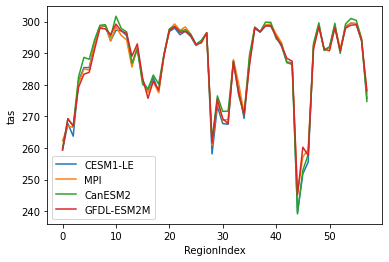

In [31]:
cesm1_avgs.plot(label='CESM1-LE')
mpi_avgs.plot(label='MPI')
canesm2_avgs.plot(label='CanESM2')
esm2m_avgs.plot(label='GFDL-ESM2M')

plt.legend()

#### Check that files can be loaded and concatenated.

In [56]:
cesm1_pic_tseries_paths = glob.glob('%s/%s/*.nc' % (save_dir,model_subdir))
cesm1_pic_tseries_paths.sort()

In [57]:
cesm1_pic_all_tseries = xr.open_mfdataset(cesm1_pic_tseries_paths,chunks={'time':-1})

In [35]:
cesm1_pic_all_tseries['TREFHT'].chunk({'time':-1})

<xarray.DataArray 'TREFHT' (time: 21612, RegionIndex: 46)>
dask.array<rechunk-merge, shape=(21612, 46), dtype=float64, chunksize=(21612, 46), chunktype=numpy.ndarray>
Coordinates:
    RegionName    (RegionIndex) object dask.array<chunksize=(46,), meta=np.ndarray>
    RegionAbbrev  (RegionIndex) object dask.array<chunksize=(46,), meta=np.ndarray>
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45
  * time          (time) object 0400-02-01 00:00:00 ... 2201-01-01 00:00:00

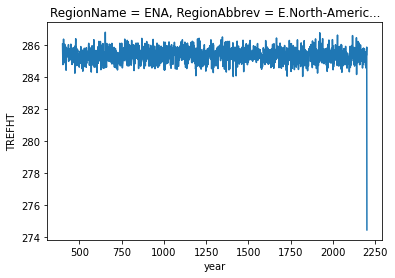

In [46]:
cesm1_pic_all_tseries['TREFHT'].sel(RegionIndex=5).groupby('time.year').mean('time').plot()

In [58]:
cesm1_pic_all_tseries.time

<xarray.DataArray 'time' (time: 21612)>
array([cftime.DatetimeNoLeap(400, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(400, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(400, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2200, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2200, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2201, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0400-02-01 00:00:00 ... 2201-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds